# Mortality Rates in the Netherlands

> Last updated April 25, 2020

Source data:
- [Weekly mortatlity](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=70895ned&_theme=75) (Statistics Netherlands)
- [Montly population](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=37943ned&_theme=62) (Statististics Netherlands)
- [Daily COVID-19 deaths](https://www.rivm.nl/coronavirus-covid-19/grafieken) (National Institute for Public Health & Environment)

Note that reporting methodology has slightly changed for weekly mortality statistics [since April 24](https://www.cbs.nl/en-gb/corporate/2020/16/how-cbs-reports-on-mortality-during-the-coronavirus-crisis). Overall mortality is updated in a more timely fashion. Gender/age breakdown is not available (encoded as `.` in the dataset, which has been manually removed/replaced to prevent the import from breaking).

In [1]:
import pandas as pd

In [5]:
deceased = pd.read_csv(
    'weeklydeaths20201011.csv',
    sep=';',
    names=['id', 'sex', 'age', 'per', 'd'],
    skiprows=1,  # skip header
    dtype={'id':int,'sex':int,'age':int,'per':str,'d':int}
)

In [6]:
period_filters = (
    ~deceased.per.str.contains('X0') &  # remove incomplete first weeks of year
    ~deceased.per.str.contains('W101') &  # remove first weeks of year that could start in prev year
    ~deceased.per.str.contains('W152') &  # remove incomplete last week of year
    ~deceased.per.str.contains('W153') &  # remove incomplete last week of year (in 2011)
    ~deceased.per.str.contains('JJ')  # remove full year data contained in series
)

In [7]:
deceased = deceased[period_filters]

In [8]:
deceased['dt'] = pd.to_datetime(deceased.per + str(1), format='%GW1%V%u')

In [9]:
# confirm the only date format that remains is in W-format (weeks)
sum(deceased.per.str.contains('W')) == len(deceased.per.str.contains('W'))

True

In [10]:
# confirm that the inferred year matches the year in the period column
[int(year) for year in deceased.per.str[:4].tolist()] == pd.DatetimeIndex(deceased['dt']).year.tolist()

True

In [11]:
# keep only broad demographics (all genders and ages)
all_genders = deceased['sex']==1100
all_ages = deceased['age']==10000

demo_filters = all_genders & all_ages

In [12]:
deceased = deceased[demo_filters]

In [13]:
# cleanup columns
deceased = deceased.drop(['id','sex','age','per'], axis=1)

In [14]:
deceased

,d,dt
2,2823,1995-01-09
3,2609,1995-01-16
4,2664,1995-01-23
5,2577,1995-01-30
6,2536,1995-02-06
...,...,...
1386,2672,2020-08-31
1387,2727,2020-09-07
1388,2694,2020-09-14
1389,2865,2020-09-21


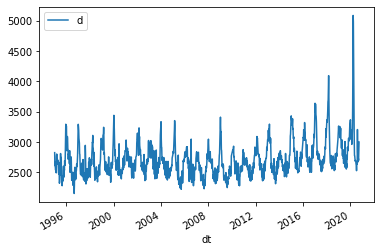

In [15]:
# quick plot show no spikes other than expected yearly seasonality
deceased.plot(x='dt')

In [16]:
pop = pd.read_csv(
    'population20201011.csv',
    sep=';',
    usecols=[1, 9],
    names=['per', 'pop'],
    skiprows=1,  # skip header
    dtype={'per':str,'pop':int}
)

In [17]:
year_filters = (
    ~pop.per.str.contains('JJ') &
    ~pop.per.str.contains('KW')
)

In [18]:
pop = pop[year_filters]

In [19]:
pop['dt'] = pd.to_datetime(pop.per, format='%YMM%m')

In [20]:
pop = pop.drop('per', axis=1)

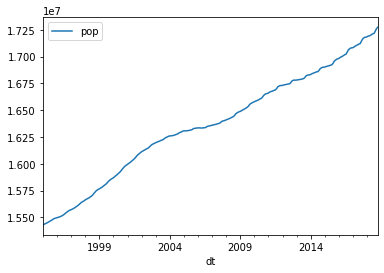

In [21]:
# quick plot to confirm data - population grew from roughly 15 to >17 million
pop.plot(x='dt')

In [22]:
pop.head()

,pop,dt
0,15430178,1995-01-01
1,15436176,1995-02-01
2,15441920,1995-03-01
4,15446212,1995-04-01
5,15452370,1995-05-01


In [23]:
# merge on month grouper (population data is not available at weekly granularity)
merged = pd.merge(
    deceased.assign(grouper=deceased['dt'].dt.to_period('M')),
    pop.assign(grouper=pop['dt'].dt.to_period('M')),
    how='left',
    on='grouper'
)

In [24]:
# cleanup columns
merged = merged.drop(['grouper', 'dt_y'], axis=1).fillna(method='ffill')

In [25]:
# compute mortality rate (typically reported as deaths per 1000)
merged['mrate'] = merged['d'] / merged['pop'] * 1000

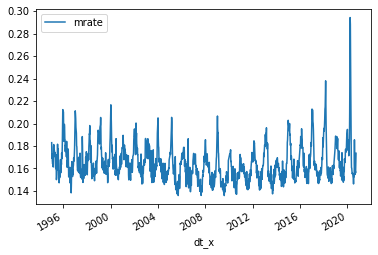

In [26]:
# quick plot to confirm data is properly scaled
merged.plot(x='dt_x', y='mrate')

In [27]:
# last three available weeks
merged[-3:]

,d,dt_x,pop,mrate
1286,2694,2020-09-14,17273746.0,0.155959
1287,2865,2020-09-21,17273746.0,0.165859
1288,2998,2020-09-28,17273746.0,0.173558


In [28]:
# create week and year columns for plot data
merged['week'] = merged.dt_x.dt.week
merged['year'] = merged.dt_x.dt.year

In [29]:
plotdata = merged.pivot(index='week',columns='year',values='mrate')

In [30]:
# convert to string headers as integers break pandas/bokeh
plotdata.columns = [str(header) for header in plotdata.columns.tolist()]

In [31]:
plotdata['mn'] = plotdata.iloc[:,:-1].mean(axis=1)  # calculate means for 1995-2019

In [32]:
plotdata['s'] = plotdata.iloc[:,:-2].std(axis=1)  # calculate standard deviations for 1995-2019

In [33]:
plotdata['upper'] = plotdata['mn'] + 2 * plotdata['s']  # upper 2-sigma CI level

In [34]:
plotdata['lower'] = plotdata['mn'] - 2 * plotdata['s']  # lower 2-sigma CI level

In [35]:
plotdata = plotdata.drop('s', axis=1)  # remove standard deviation from plotdata

In [46]:
cd = pd.read_csv(
    'coronadeaths20201011.csv',
    sep=';',
    names=['date', 'new', 'known'],
    skiprows=1,
    dtype={'date':str,'new':int,'known':int}
)

In [47]:
cd.date = cd.date + ' 2020'

In [48]:
for i in range(len(cd.date.tolist())):
    if cd.date[i][1] == ' ':
        cd.date[i] = '0' + str(cd.date[i])
    cd.date[i] = str(cd.date[i]).replace('feb', 'February')
    cd.date[i] = str(cd.date[i]).replace('mrt', 'March')
    cd.date[i] = str(cd.date[i]).replace('apr', 'April')
    cd.date[i] = str(cd.date[i]).replace('mei', 'May')
    cd.date[i] = str(cd.date[i]).replace('jun', 'June')
    cd.date[i] = str(cd.date[i]).replace('jul', 'July')
    cd.date[i] = str(cd.date[i]).replace('aug', 'August')
    cd.date[i] = str(cd.date[i]).replace('sep', 'September')
    cd.date[i] = str(cd.date[i]).replace('okt', 'October')

/Users/gid/code/nl-mortality-covid/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/gid/code/nl-mortality-covid/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/gid/code/nl-mortality-covid/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [49]:
cd.index = pd.to_datetime(cd.date, format='%d %B %Y')

In [50]:
cdw = cd.resample('W').sum()

In [51]:
cdw['total'] = cdw.new + cdw.known

In [52]:
cdw

,new,known,total
date,,,
2020-03-01,0,0,0
2020-03-08,0,4,4
2020-03-15,0,36,36
2020-03-22,0,291,291
2020-03-29,0,790,790
2020-04-05,0,1173,1173
2020-04-12,0,1034,1034
2020-04-19,0,882,882
2020-04-26,0,701,701


In [53]:
cdw.index = [i.isocalendar()[1] for i in cdw.index]
cdw.index.name = 'week'

In [54]:
cdw

,new,known,total
week,,,
9,0,0,0
10,0,4,4
11,0,36,36
12,0,291,291
13,0,790,790
14,0,1173,1173
15,0,1034,1034
16,0,882,882
17,0,701,701


In [63]:
for i in cdw.index[1:35]:
    plotdata.loc[i, 'coronadeaths'] = (cdw.loc[i, 'total'] / merged.loc[1262, 'pop'] * 1000) + plotdata.loc[i, 'mn']

In [64]:
# quick sanity check to confirm 2020 mortality and COVID mortality are as expected.
plotdata.head(50)

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,mn,upper,lower,coronadeaths
week,,,,,,,,,,,,,,,,,,,,,
2,0.182953,0.210162,0.211274,0.163309,0.190588,0.216636,0.178304,0.195185,0.184409,0.204989,...,0.202866,0.181056,0.212892,0.195458,0.188841,0.194746,0.186908,0.219063,0.154754,NaN
3,0.169084,0.191643,0.208641,0.154371,0.185070,0.208381,0.181742,0.188172,0.184038,0.187892,...,0.199790,0.180291,0.204112,0.195749,0.182473,0.182705,0.182124,0.213671,0.150577,NaN
4,0.172649,0.184222,0.204531,0.161521,0.181772,0.201828,0.189495,0.191089,0.182927,0.179650,...,0.198370,0.188475,0.212248,0.193305,0.184037,0.176337,0.181447,0.210990,0.151904,NaN
5,0.167010,0.193062,0.196568,0.171800,0.188420,0.186957,0.183055,0.182338,0.174160,0.178789,...,0.196536,0.182615,0.209204,0.198018,0.181721,0.183052,0.180877,0.205971,0.155783,NaN
6,0.164289,0.199280,0.193358,0.166877,0.196852,0.178530,0.178770,0.177369,0.169419,0.169175,...,0.193526,0.178672,0.201621,0.204339,0.184268,0.184847,0.180128,0.206206,0.154050,NaN
7,0.165261,0.196506,0.191303,0.171982,0.197993,0.174626,0.172521,0.172344,0.168863,0.165547,...,0.195833,0.178143,0.199924,0.212889,0.188378,0.185136,0.179369,0.207149,0.151590,NaN
8,0.162605,0.186248,0.180197,0.173514,0.198691,0.180671,0.167772,0.183449,0.180405,0.168867,...,0.199973,0.195327,0.194717,0.214692,0.186410,0.171300,0.181058,0.208604,0.153512,NaN
9,0.161309,0.185667,0.179235,0.167643,0.205385,0.168328,0.171771,0.200447,0.186453,0.167392,...,0.189682,0.187441,0.184420,0.229001,0.177437,0.179289,0.180401,0.213666,0.147137,NaN
10,0.179382,0.175046,0.169416,0.179383,0.195055,0.169298,0.180870,0.186987,0.184560,0.167253,...,0.190539,0.185376,0.178609,0.237994,0.183631,0.179695,0.180483,0.212848,0.148117,0.180714


In [65]:
from bokeh.plotting import figure, output_file, save
from bokeh.models import Span, Label, Title

In [ ]:
output_file('mortality.html', title='Mortality Rate in the Netherlands')

cols=len(plotdata.columns)

fig = figure(
    tools='pan,wheel_zoom,box_zoom,save,reset',
    x_axis_label='Week Number',
    x_minor_ticks=10,
    x_range=[1,52],
    y_range=[0.1,0.3],
    y_axis_label='Mortality Rate (per 1000 citizens)',
    plot_width=1000,
    plot_height=600,
    toolbar_location='above'
)

fig.title.text = 'Weekly Mortality Rate in the Netherlands 1995-2020'
fig.title.align = 'center'
fig.title.text_font_size = '25px'

fig.add_layout(
    Title(
        text='Source: Statistics Netherlands (2020), RIVM (2020). Preliminary data for 2019 and 2020.', 
        align='left',
        text_font_size='12px'
    ),
    'below'
)


fig.add_layout(Span(
    location=9,
    dimension='height',
    line_color='red',
    line_dash='dashed',
    line_width=1.5,
    line_alpha=0.5
))

fig.add_layout(Label(
    x=1.5,
    y=0.261,
    text='First COVID-19 death',
    render_mode='css',
    text_font_size='14px'
))

for i in range(cols-4):  # add all historic years
    fig.line(
        x=plotdata.index,
        y=plotdata.iloc[:,i],
        line_color='grey',
        line_alpha=0.15,
        line_width=1
    )

fig.line(
    x=plotdata.index,
    y=plotdata.mn,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    legend_label='Average (1995-2019)'
)

fig.line(
    x=plotdata.index,
    y=plotdata.upper,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    line_dash='dotted',
    legend_label='95% CI (1995-2019)'
)

fig.line(
    x=plotdata.index,
    y=plotdata.lower,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    line_dash='dotted'
)


fig.line(
    x=plotdata.index,
    y=plotdata['2020'],
    line_color='red',
    line_alpha=1,
    line_width=3,
    legend_label='2020'
)

fig.line(
    x=plotdata.index,
    y=plotdata['coronadeaths'],
    line_color='red',
    line_alpha=1,
    line_width=3,
    line_dash='dashed',
    legend_label='Avg + reported COVID-19 deaths (RIVM)'
)

save(fig)